# FaceForensics Detection Using Spectral Analysis

This notebook is heavily based on the work presented [here](https://github.com/cc-hpc-itwm/DeepFakeDetection). Please visit
the original work for further information.

### 1. Create feature

First, download the image dataset using this [link](https://drive.google.com/drive/folders/19qllKobm2USPuE-hrFSQDb34KWJ5Ud6M?usp=sharing)


#### 1.1 Import the necessary libraries

In [1]:
import cv2
import numpy as np
import os
import radialProfile
import glob
from matplotlib import pyplot as plt
import pickle
from scipy.interpolate import griddata

#### 1.2. Set up the parameters for the spectral decomposition
The parameters are:
- data: dictionary that saves each image data and its label, 0 for fake and 1 for true
- epsilon: small value added such that we won't have to compute log(0), which is not defined (see later Section x.)
- N: final number of features used for classification
- y: list for storing labels
- error: list for storing error
- number iter: number of images used

In [19]:
data= {}
epsilon = 1e-8
N = 80
y = []
error = []

number_iter = 995

Declare the following variables:
- psd1D_total: $number\_iter \times N$ array. Here we save the N features of each one of the $number\_iter$ images after performing the spectral decomposition
- label_total: save label for all images
- psd1D_org_mean: result of computing the mean value for each feature
- psd1D_org_std: result of computing the standard deviation for each feature

In [20]:
psd1D_total = np.zeros([number_iter, N])
label_total = np.zeros([number_iter])
psd1D_org_mean = np.zeros(N)
psd1D_org_std = np.zeros(N)

#### 1.4. Compute the spectral decomposition for each image
**Attention!** You have to manually change the path for the

First, load images and crop them. Next, compute the features.

To compute the features:
1. Compute the 2D FT of each image.
2. Shift the zero-component to the center of the image using np.fftshit().
3. Add epsilon to avoid log(0) later. This step is necessary for avoiding numerical issues in step 4.
4. Compute magnitude spectrum:
$
\begin{align}
magnitude = 20 * log(abs(fft\_decomposition))
\end{align}
$
For this, use the formula for expressing magnitude in decibels:
$ydb = 20 * log_{10}(y)$, where y is the input signal. For reference check for example the [Matlab documentation](https://www.amazon.com/Useless-Magic-Lyrics-Florence-Welch/dp/0525577157/ref=tmm_hrd_swatch_0?_encoding=UTF8&qid=&sr=).
5. Compute the Azimuthal Mean: check implementation in /Experiments_DeepFakeDetection/radial_profile.py.
6. Finally, use the computed averages and interpolate to get the N features


**Don't forget that for now data paths are set manually**

In [21]:
# counter for number of processed images
cont = 0

# fake data
# rootdir = 'dataset_celebA/'
rootdir = '/home/anaradutoiu/Documents/Sem_2/EAI/projects/DeepFakeDetection/faceforensics/deepfakes/c23/jpg-nonresized'

for filename in glob.glob(rootdir+"/*"):
    img = cv2.imread(filename,0)

    h = int(img.shape[0]/3)
    w = int(img.shape[1]/3)
    img = img[h:-h,w:-w]

    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    fshift += epsilon
    
    magnitude_spectrum = 20 * np.log(np.abs(fshift))
    psd1D = radialProfile.azimuthalAverage(magnitude_spectrum)

    # Calculate the azimuthally averaged 1D power spectrum
    points = np.linspace(0,N,num=psd1D.size) # coordinates of a
    xi = np.linspace(0,N,num=N) # coordinates for interpolation

    interpolated = griddata(points,psd1D,xi,method='cubic')
    interpolated /= interpolated[0]


    psd1D_total[cont,:] = interpolated             
    label_total[cont] = 1
    if cont % 50 == 0:
        print("Processed {}/{} images".format(cont, number_iter))

    cont+=1

    if cont == number_iter:
        print("Finished processing")
        break

Processed 0/995 images
Processed 50/995 images
Processed 100/995 images
Processed 150/995 images
Processed 200/995 images
Processed 250/995 images
Processed 300/995 images
Processed 350/995 images
Processed 400/995 images
Processed 450/995 images
Processed 500/995 images
Processed 550/995 images
Processed 600/995 images
Processed 650/995 images
Processed 700/995 images
Processed 750/995 images
Processed 800/995 images
Processed 850/995 images
Processed 900/995 images
Processed 950/995 images
Finished processing


Now we can compute the mean and std for each feature using the values from each image

In [22]:
for x in range(N):
    psd1D_org_mean[x] = np.mean(psd1D_total[:,x])
    psd1D_org_std[x]= np.std(psd1D_total[:,x])
    

Moving on to processing the real data.

**Attention:** you have to manually set the path to celebA

In [23]:
## real data
psd1D_total2 = np.zeros([number_iter, N])
label_total2 = np.zeros([number_iter])
psd1D_org_mean2 = np.zeros(N)
psd1D_org_std2 = np.zeros(N)

cont = 0
# rootdir2 = '/home/anaradutoiu/Documents/Sem_2/EAI/projects/DeepFakeDetection/imgs/img_align_celeba_small/'
rootdir2 = '/home/anaradutoiu/Documents/Sem_2/EAI/projects/DeepFakeDetection/faceforensics/real/c23/jpg-nonresized'

for filename in glob.glob(rootdir2+"/*"):
    img = cv2.imread(filename,0)

    # we crop the center
    h = int(img.shape[0]/3)
    w = int(img.shape[1]/3)
    img = img[h:-h,w:-w]

    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    fshift += epsilon

    magnitude_spectrum = 20*np.log(np.abs(fshift))

    # Calculate the azimuthally averaged 1D power spectrum
    psd1D = radialProfile.azimuthalAverage(magnitude_spectrum)

    points = np.linspace(0,N,num=psd1D.size) # coordinates of a
    xi = np.linspace(0,N,num=N) # coordinates for interpolation

    interpolated = griddata(points,psd1D,xi,method='cubic')

    interpolated /= interpolated[0]

    psd1D_total2[cont,:] = interpolated             
    label_total2[cont] = 0
    if cont % 50 ==0:
        print("Processed {}/{} images".format(cont, number_iter))
    cont+=1
    
    if cont == number_iter:
        print("Finished processing")
        break

Processed 0/995 images
Processed 50/995 images
Processed 100/995 images
Processed 150/995 images
Processed 200/995 images
Processed 250/995 images
Processed 300/995 images
Processed 350/995 images
Processed 400/995 images
Processed 450/995 images
Processed 500/995 images
Processed 550/995 images
Processed 600/995 images
Processed 650/995 images
Processed 700/995 images
Processed 750/995 images
Processed 800/995 images
Processed 850/995 images
Processed 900/995 images
Processed 950/995 images
Finished processing


Compute mean and standard deviation:

In [24]:
for x in range(N):
    psd1D_org_mean2[x] = np.mean(psd1D_total2[:,x])
    psd1D_org_std2[x]= np.std(psd1D_total2[:,x])

Save the computed values in a pickle object

In [25]:
y.append(psd1D_org_mean)
y.append(psd1D_org_mean2)
error.append(psd1D_org_std)
error.append(psd1D_org_std2)

psd1D_total_final = np.concatenate((psd1D_total,psd1D_total2), axis=0)
label_total_final = np.concatenate((label_total,label_total2), axis=0)

data["data"] = psd1D_total_final
data["label"] = label_total_final

output = open('train_3200.pkl', 'wb')
pickle.dump(data, output)
output.close()

print("DATA Saved") 

DATA Saved


### 2. Loading Features

Now, we load the features. Either the pre-computed ones or the features that you have created.

In [26]:
# load feature file
pkl_file = open('train_3200.pkl', 'rb')
data = pickle.load(pkl_file)
pkl_file.close()
X = data["data"]
y = data["label"]

We look at the label distribution, to be sure that we have a balanced dataset.

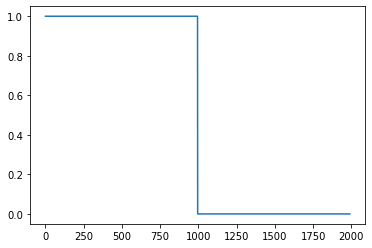

In [27]:
plt.plot(y)
plt.show()

### 3. Check Spectrum

We have a look to the spectrum. First, we initialize our variables:

In [28]:
num = int(X.shape[0]/2)
num_feat = X.shape[1]

psd1D_org_0 = np.zeros((num,num_feat))
psd1D_org_1 = np.zeros((num,num_feat))
psd1D_org_0_mean = np.zeros(num_feat)
psd1D_org_0_std = np.zeros(num_feat)
psd1D_org_1_mean = np.zeros(num_feat)
psd1D_org_1_std = np.zeros(num_feat)

cont_0 = 0
cont_1 = 0

# We separate real and fake using the label
for x in range(X.shape[0]):
    if y[x]==0:
        psd1D_org_0[cont_0,:] = X[x,:]
        cont_0+=1
    elif y[x]==1:
        psd1D_org_1[cont_1,:] = X[x,:]
        cont_1+=1

Next, we compute the statistics

In [29]:
for x in range(num_feat):
    psd1D_org_0_mean[x] = np.mean(psd1D_org_0[:,x])
    psd1D_org_0_std[x]= np.std(psd1D_org_0[:,x])
    psd1D_org_1_mean[x] = np.mean(psd1D_org_1[:,x])
    psd1D_org_1_std[x]= np.std(psd1D_org_1[:,x])

Finally we can plot the mean value and std of the frequency components

Text(0, 0.5, 'Power Spectrum')

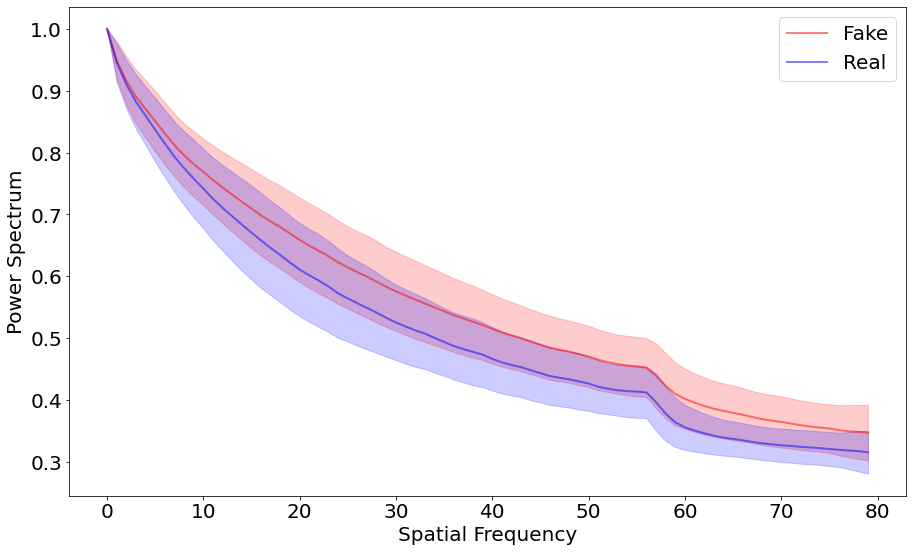

In [30]:
# Plot
x = np.arange(0, num_feat, 1)
fig, ax = plt.subplots(figsize=(15, 9))
ax.plot(x, psd1D_org_0_mean, alpha=0.5, color='red', label='Fake', linewidth =2.0)
ax.fill_between(x, psd1D_org_0_mean - psd1D_org_0_std, psd1D_org_0_mean + psd1D_org_0_std, color='red', alpha=0.2)
ax.plot(x, psd1D_org_1_mean, alpha=0.5, color='blue', label='Real', linewidth =2.0)
ax.fill_between(x, psd1D_org_1_mean - psd1D_org_1_std, psd1D_org_1_mean + psd1D_org_1_std, color='blue', alpha=0.2)

plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
ax.legend(loc='best', prop={'size': 20})
plt.xlabel("Spatial Frequency", fontsize=20)
plt.ylabel("Power Spectrum", fontsize=20)
#plt.savefig('1000_celeba.png', bbox_inches='tight')

### 4. Classification

Now we classify using the features.

In [31]:
num = 10
LR = 0
SVM = 0
SVM_r = 0
SVM_p = 0


for z in range(num):
    # read python dict back from the file
    pkl_file = open('train_3200.pkl', 'rb')
    
    data = pickle.load(pkl_file)

    pkl_file.close()
    X = data["data"]
    y = data["label"]


    try:

        from sklearn.model_selection import train_test_split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

        from sklearn.svm import SVC
        svclassifier = SVC(kernel='linear')
        svclassifier.fit(X_train, y_train)
        #print('Accuracy on test set: {:.3f}'.format(svclassifier.score(X_test, y_test)))
               
        from sklearn.svm import SVC
        svclassifier_r = SVC(C=6.37, kernel='rbf', gamma=0.86)
        svclassifier_r.fit(X_train, y_train)
        #print('Accuracy on test set: {:.3f}'.format(svclassifier_r.score(X_test, y_test)))
                
        from sklearn.svm import SVC
        svclassifier_p = SVC(kernel='poly')
        svclassifier_p.fit(X_train, y_train)
        #print('Accuracy on test set: {:.3f}'.format(svclassifier_p.score(X_test, y_test)))
        
        from sklearn.linear_model import LogisticRegression
        logreg = LogisticRegression(solver='liblinear', max_iter=1000)
        logreg.fit(X_train, y_train)
        #print('Accuracy on test set: {:.3f}'.format(logreg.score(X_test, y_test)))

        
        SVM+=svclassifier.score(X_test, y_test)
        SVM_r+=svclassifier_r.score(X_test, y_test)
        SVM_p+=svclassifier_p.score(X_test, y_test)
        LR+=logreg.score(X_test, y_test)

        
    except:
        num-=1
        print(num)

Let's finally print the results

In [32]:
print("Average SVM: "+str(SVM/num))
print("Average SVM_r: "+str(SVM_r/num))
print("Average SVM_p: "+str(SVM_p/num))
print("Average LR: "+str(LR/num))

Average SVM: 0.7391959798994974
Average SVM_r: 0.815075376884422
Average SVM_p: 0.8067839195979898
Average LR: 0.7381909547738694
